# Qaintellect training example 1: qubit rotation

(Adapted from PennyLane's qubit rotation tutorial)

In this example, we will demonstrate the optimisation of a quantum circuit using Qaintellect's Flux integration.

In [1]:
using Qaintellect
using LinearAlgebra
using Flux
using IterTools: ncycle

In the first task, we would like to optimize a circuit such that it flips a qubit from state $\lvert 0 \rangle$ to $\rvert 1 \rangle$. We begin by constructing a simple circuit consisting of two rotation gates: an $R_{x}$ gate and an $R_{y}$ gate

<div>
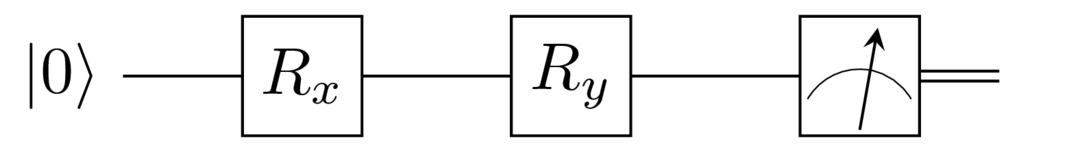
</div>

where:

$$
R_{x}(\theta) = \mathrm{e}^{-i \theta X / 2} = \begin{pmatrix} \cos\frac{\theta}{2}& -i \sin\frac{\theta}{2}\\ -i \sin\frac{\theta}{2}& \cos\frac{\theta}{2} \end{pmatrix} \\
R_{y}(\theta) = \mathrm{e}^{-i \theta Y / 2} = \begin{pmatrix} \cos\frac{\theta}{2}& -\sin\frac{\theta}{2}\\ \sin\frac{\theta}{2}& \cos\frac{\theta}{2} \end{pmatrix}
$$

We create $R_{x}$ and $ R_{y}$ gates, with randomized initial rotation angles:

In [2]:
rx = RxGate(2π*rand())
ry = RyGate(2π*rand())

@show(rx)
@show(ry)

rx = RxGate([0.2852979630949063])
ry = RyGate([5.897114323717471])


RyGate([5.897114323717471])

Then, we setup the quantum circuit using these gates. We use the Pauli-$Z$ matrix as an observable, noting that measuring with this observable yields $-1$ when measuring the target $ \lvert 1 \rangle$ state.

In [3]:
cgc = [
    circuit_gate(1, rx),
    circuit_gate(1, ry),
]

# using Pauli-Z matrix as observable
meas = [MeasurementOperator([1 0; 0 -1], (1,))]

c = Circuit{1}(cgc, meas)


    1 —[Rx]——[Ry]—


We set the initial input as the $\lvert 0 \rangle$ state, and the target expectation value of the measurement as $-1$.

In [4]:
ψ = ComplexF64[1, 0]
e = -1
@show(ψ)

ψ = Complex{Float64}[1.0 + 0.0im, 0.0 + 0.0im]


2-element Array{Complex{Float64},1}:
 1.0 + 0.0im
 0.0 + 0.0im

Now, we define a cost function `loss()` using the Flux mean-squared error function. We also gather the trainable params from our created circuit using the`Flux.params` function.

In [5]:
# create loss function: note that circuit `c` is applied to `x`
loss(x, y) = Flux.mse(c(x), y)

# gather parameters from Circuit
paras = Flux.params(c)
@show(paras)

# define optimizer
opt = ADAM(0.5)

# set up data for training; using `ncycle()` to repeatedly feed the input quantum state into the training algorithm
data = ncycle([(ψ, e)], 128)

# define evaluation function
evalcb() = @show(loss(ψ, e))

paras = Params([[0.2852979630949063], [5.897114323717471], 
  [1, 1]  =  1.0+0.0im
  [2, 2]  =  -1.0+0.0im])


evalcb (generic function with 1 method)

In [6]:
# example: compute gradients
grads = gradient(() -> loss(ψ, e), paras)
grads[ry.θ]

1-element Array{Float64,1}:
 1.3650695278938842

Finally, let Flux optimize the circuit parameters:

In [7]:
Flux.train!(loss, paras, data, opt, cb=Flux.throttle(evalcb, 0.01))

loss(ψ, e) = 2.094566636677492


In [8]:
# optimized parameters
paras

Params([[-0.06611831314621944], [3.1552160317265447], 
  [1, 1]  =  1.0+0.0im
  [2, 2]  =  -1.0+0.0im])

We can verify that our trained circuit now (approximately) produces the desired output:

In [9]:
apply(ψ, c)

1-element Array{Float64,1}:
 -0.9977223864977636